<h1>Is AI able to detect brain cancer?</h1>
<h2>Brain MRI classification using Convolutional Neural Network</h2>

<h3> Import libraries </h3>

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from zipfile import ZipFile
import os
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout

from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Importing zip file with data
def unpack_zip(name):
    with ZipFile(name, 'r') as zip_ref:
        zip_ref.extractall('data')
    


In [2]:
unpack_zip('data.zip')

<h3> Import data </h3>

We need to import data twice, because RandomForestClassifier has different input type than used CNN networks.

In [12]:
def progress_bar(idx_val):
    if idx_val % 100 == 0:
        print('*', end='')

In [10]:
resize = 150
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor','pituitary_tumor']
def uploading_image(test_train, i, idx, flag, X_num, y_num):
    path = os.path.join('data',test_train, i)
    for img in os.listdir(path):
        img_upload = cv2.imread(os.path.join(path, img))
        img_upload = cv2.resize(img_upload,(resize, resize))
        if flag == 2:
            img_upload = img_upload.ravel()
        X_num.append(img_upload)
        y_num.append(labels.index(i))
        idx +=1
        progress_bar(idx)

In [13]:
X = []
y = []
idx = 0
X2 = []
y2 = []
idx2 = 0
for i in labels:
    uploading_image('Testing', i, idx, 1, X, y)
    uploading_image('Testing', i, idx2, 2, X2, y2)
    uploading_image('Training', i, idx, 1, X, y)
    uploading_image('Training', i, idx2, 2, X2, y2)
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y)
X2 = np.array(X2)
y2 = np.array(y2)
    

************************************************************

<h3> Shuffling data </h3>

We need to shuffle the data to avoid human interference in data distribution. <br>Our dataset has already been divided into training and testing set, but we import it all together and now we are suffling the images.

In [6]:
X, y = sklearn.utils.shuffle(X,y, random_state=44)
scaler=MinMaxScaler()
X2=scaler.fit_transform(X2)
X2, y2 = sklearn.utils.shuffle(X2,y2, random_state=44)

In [14]:
print(X.shape)
print(y.shape)
print(y[0])
print(X2[0])

(3264, 150, 150, 3)
(3264, 4)
[1. 0. 0. 0.]
[0 0 0 ... 0 0 0]


<h3>Dataset split into train and test sets</h3>

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=44)
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2, test_size=0.2,random_state=44)

In [24]:
print(len(y_test))
print(len(y_train))

653
2611


<h3> Example images </h3>

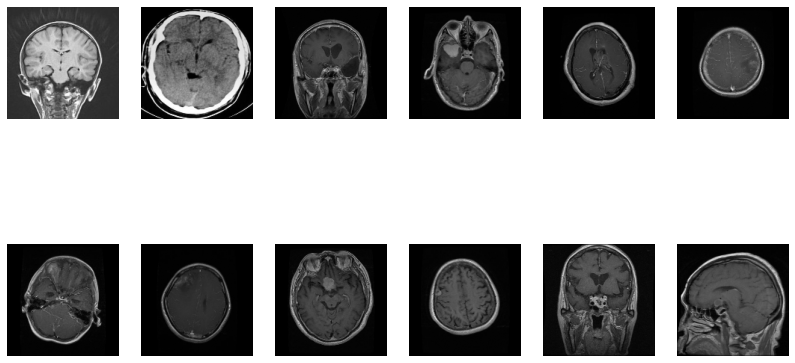

In [11]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14, 8)) 
ax = ax.ravel()
for i in range(12):
    ax[i].imshow(X_train[i]/255) 
    ax[i].axis('off')

<h3>Distribution of test and train sets</h3>

In [46]:
def to_print(y_train_or_test):
    y_new = y_train_or_test.tolist()
    for i in range(len(y_train_or_test)):
        y_new[i] = labels[y_new[i]]
    return y_new

In [47]:
y_test_print = to_print(y_test2)
y_train_print = to_print(y_train2)

Every class have similar number of occurrance. In both sets there is only less images without tumor.

[Text(0.5, 1.0, 'Train')]

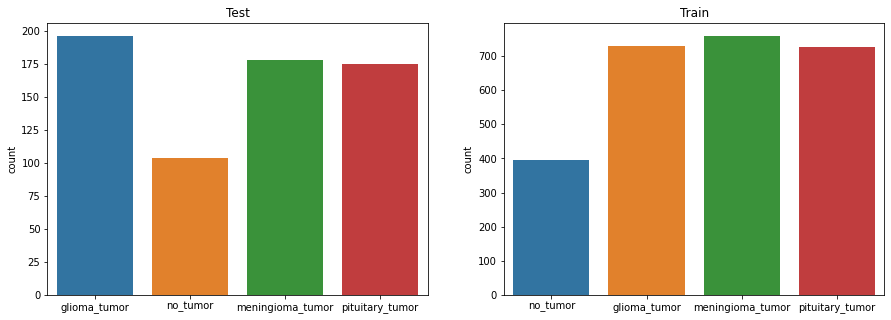

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax = ax[0], x=y_test_print).set(title="Test")
sns.countplot(ax = ax[1], x=y_train_print).set(title="Train")

<h3> Model selection </h3>

First model has my own implementation. It is a convolutional neural network, made using Sequential model from Keras and adding chosen layers with specific parameters. <br>
In this model, Conv2D layes is mostly used, because convolutional layers have good outcome in image classification problem. It allows the next layer to better read and process the data.<br>
There is also used MaxPooling2D layer. It filters the processed data, choosing max value in desirible region.<br>
The Rectified Linear Unit activation function was used, because of its good outcome in classification problem.<br>
The model was extended by cyclic 4 times repetition of the use of 2 basal layers.<br>
At the end there was used Flatten layer - which change the shape of given data, the Droput layer, which allows to delete some neurons from network, and 2 simpliest Dense layers.<br>
In last layer the activation function was Softmax, which scales given data into probabilities and gives the output. <br>

In compilation the Categorical Crossentropy loss function was used, because we have multiple classification problem. The best optimizer was Adam. 

In [15]:
model = Sequential() 

model.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3, 3)))                                 
                                                                            
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))                                  
                                                                     
model.add(Conv2D(256, (3, 3), activation='relu'))                    
model.add(MaxPooling2D(pool_size=(1, 1))) 

model.add(Conv2D(512, (1, 1), activation='relu')) 
model.add(MaxPooling2D(pool_size=(1, 1))) 

model.add(Flatten())                                                    
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))                                                 
model.add(Dense(4, activation='softmax'))                               


model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
                                                                                    

After fitting the first model had a 94% accuracy on a validation set 

In [16]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.06)  

Epoch 1/20
77/77 [==============================] - 43s 555ms/step - loss: 21.3568 - accuracy: 0.4678 - val_loss: 0.9157 - val_accuracy: 0.7516
Epoch 2/20
77/77 [==============================] - 42s 548ms/step - loss: 0.9610 - accuracy: 0.5815 - val_loss: 0.7621 - val_accuracy: 0.7962
Epoch 3/20
77/77 [==============================] - 42s 550ms/step - loss: 0.7446 - accuracy: 0.6919 - val_loss: 0.6019 - val_accuracy: 0.7771
Epoch 4/20
77/77 [==============================] - 42s 551ms/step - loss: 0.6218 - accuracy: 0.7461 - val_loss: 0.4458 - val_accuracy: 0.8726
Epoch 5/20
77/77 [==============================] - 42s 550ms/step - loss: 0.4757 - accuracy: 0.8024 - val_loss: 0.3994 - val_accuracy: 0.8662
Epoch 6/20
77/77 [==============================] - 42s 552ms/step - loss: 0.3741 - accuracy: 0.8500 - val_loss: 0.3957 - val_accuracy: 0.8726
Epoch 7/20
77/77 [==============================] - 43s 552ms/step - loss: 0.3305 - accuracy: 0.8586 - val_loss: 0.3189 - val_accuracy: 0.866

In [17]:
model.save('model_my.h5')

The second model is a representation of Transfer Learning. There is used EfficientNetV2S model, which was pretrained. We only add the last layers.

In [22]:
pre_trained = EfficientNetV2S(input_shape=(150,150,3), include_top=False, weights='imagenet') 

In [23]:
new_layer = layers.Flatten()(pre_trained.output)
new_layer = layers.Dense(64, activation='relu')(new_layer)
new_layer = layers.Dropout(0.4)(new_layer)
new_layer = layers.Dense(4, activation='softmax')(new_layer)
model2 = Model(pre_trained.input, new_layer)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]']          

After fitting the second model had a 97% accuracy on a validation set 

In [25]:
history2 = model2.fit(X_train, y_train, epochs=10, validation_split=0.06)

Epoch 1/10
77/77 [==============================] - 250s 3s/step - loss: 0.8758 - accuracy: 0.7025 - val_loss: 0.5066 - val_accuracy: 0.8217
Epoch 2/10
77/77 [==============================] - 240s 3s/step - loss: 0.5647 - accuracy: 0.8109 - val_loss: 0.6202 - val_accuracy: 0.7389
Epoch 3/10
77/77 [==============================] - 242s 3s/step - loss: 0.4851 - accuracy: 0.8337 - val_loss: 0.6974 - val_accuracy: 0.8854
Epoch 4/10
77/77 [==============================] - 241s 3s/step - loss: 0.4963 - accuracy: 0.8525 - val_loss: 0.3067 - val_accuracy: 0.9236
Epoch 5/10
77/77 [==============================] - 244s 3s/step - loss: 0.3605 - accuracy: 0.8908 - val_loss: 3.7977 - val_accuracy: 0.8726
Epoch 6/10
77/77 [==============================] - 242s 3s/step - loss: 0.5759 - accuracy: 0.8146 - val_loss: 0.3549 - val_accuracy: 0.9299
Epoch 7/10
77/77 [==============================] - 245s 3s/step - loss: 0.3832 - accuracy: 0.8676 - val_loss: 0.1249 - val_accuracy: 0.9682
Epoch 8/10
77

In [26]:
model2.save("model_efficientnetv2s.h5")

In [34]:
new_layer = layers.Flatten()(pre_trained.output)
new_layer = layers.Dense(64, activation='relu')(new_layer)
new_layer = layers.Dropout(0.4)(new_layer)
new_layer = layers.Dense(4, activation='sigmoid')(new_layer)
model5 = Model(pre_trained.input, new_layer)
model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [35]:
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 24)   648         ['rescaling_3[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 24)   96          ['stem_conv[0][0]']        

In [36]:
from keras.callbacks import EarlyStopping
stop_early2 = EarlyStopping(patience=2)
history4 = model5.fit(X_train, y_train, epochs=10, validation_split=0.06, callbacks=[stop_early2])

Epoch 1/10
77/77 [==============================] - 238s 3s/step - loss: 1.3195 - accuracy: 0.5395 - val_loss: 8.3804 - val_accuracy: 0.5414
Epoch 2/10
77/77 [==============================] - 217s 3s/step - loss: 1.0209 - accuracy: 0.5970 - val_loss: 1.2884 - val_accuracy: 0.6178
Epoch 3/10
77/77 [==============================] - 219s 3s/step - loss: 0.7425 - accuracy: 0.7286 - val_loss: 0.6829 - val_accuracy: 0.8471
Epoch 4/10
77/77 [==============================] - 221s 3s/step - loss: 0.5928 - accuracy: 0.8199 - val_loss: 0.2236 - val_accuracy: 0.9236
Epoch 5/10
77/77 [==============================] - 223s 3s/step - loss: 0.4510 - accuracy: 0.8737 - val_loss: 0.4800 - val_accuracy: 0.8790
Epoch 6/10
77/77 [==============================] - 223s 3s/step - loss: 0.3835 - accuracy: 0.8904 - val_loss: 0.3802 - val_accuracy: 0.9108


The last model in our comparison is RandomForestClassifier, which is based on decision tree algorithm.

In [35]:
model_classifier = RandomForestClassifier(random_state=44)
model_classifier.fit(X_train2, y_train2)
pred3 = model_classifier.predict(X_test2)

<h3> Model evaluation</h3>

Accuracy of models on test set

In [111]:
def acc_loss(model_num, x_num, y_num):
    evaluation = model_num.evaluate(x_num, y_num)
    print('\nAccuracy: ')
    print(evaluation[1])
    print('\nLoss: ')
    print(evaluation[0])
    print('\n----------------------------------------------------------------\n')

In [79]:
accuracy_score(y_test2, pred3)

0.889739663093415

In [113]:
acc_loss(model, X_test, y_test)
acc_loss(model2, X_test, y_test)

21/21 [==============================] - 3s 123ms/step - loss: 0.3661 - accuracy: 0.8974

Accuracy: 
0.8973966240882874

Loss: 
0.36609962582588196

----------------------------------------------------------------

21/21 [==============================] - 12s 590ms/step - loss: 0.3067 - accuracy: 0.9464

Accuracy: 
0.9464012384414673

Loss: 
0.3067205846309662

----------------------------------------------------------------



Loss and accuracy during fitting

In [58]:
def acc_val_plot(history_num):
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    ax[0].plot(history_num.history['loss'], label='Training loss', linestyle=':') 
    ax[0].plot(history_num.history['val_loss'], label='Validation loss')          
    ax[0].set_title('Training and validation loss')                              
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel("Epoch")                                                      
    ax[0].legend()
    ax[1].plot(history_num.history['accuracy'], label='Training accuracy', linestyle=':') 
    ax[1].plot(history_num.history['val_accuracy'], label='Validation accuracy')          
    ax[1].set_title('Training and validation accuracy')                               
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')                                                     
    ax[1].legend()

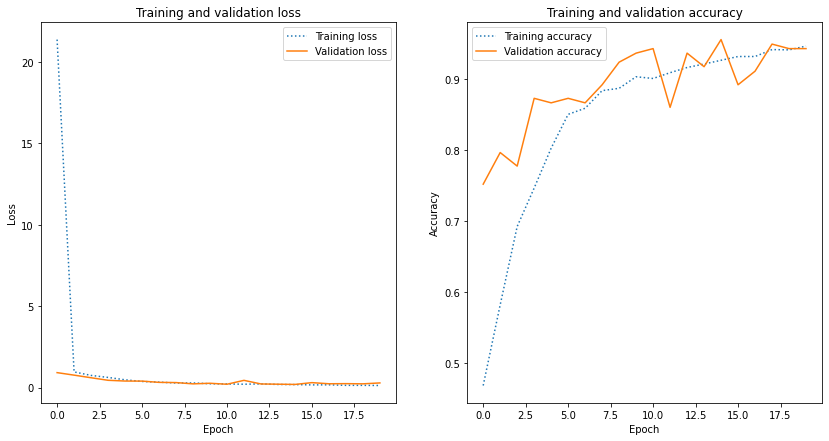

In [59]:
acc_val_plot(history)

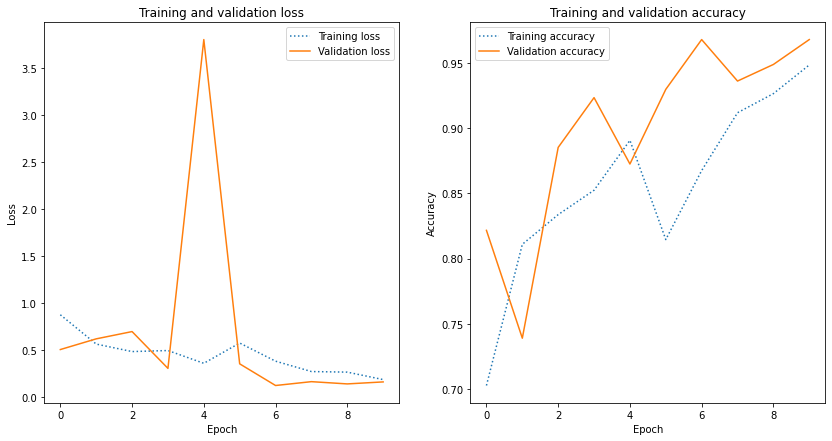

In [60]:
acc_val_plot(history2)

In [73]:
pred = model.predict(X_test)
pred2 = model2.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
pred2 = np.argmax(pred2,axis=1)

Precision of models to predict each kind of tumor

In [69]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87       196
           1       0.81      0.92      0.86       178
           2       0.88      0.87      0.87       104
           3       0.96      0.99      0.97       175

    accuracy                           0.90       653
   macro avg       0.90      0.90      0.90       653
weighted avg       0.90      0.90      0.90       653



In [76]:
print(classification_report(y_test_new,pred2))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       196
           1       0.92      0.93      0.93       178
           2       0.93      0.97      0.95       104
           3       0.98      0.97      0.97       175

    accuracy                           0.95       653
   macro avg       0.94      0.95      0.95       653
weighted avg       0.95      0.95      0.95       653



In [71]:
print(classification_report(y_test2, pred3))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       196
           1       0.81      0.90      0.86       178
           2       0.87      0.90      0.89       104
           3       0.90      0.98      0.94       175

    accuracy                           0.89       653
   macro avg       0.89      0.89      0.89       653
weighted avg       0.90      0.89      0.89       653



Confusion matrix of predicted and true labels for each model

In [92]:
labels_list = [i for i in range(4)]
cm1 = confusion_matrix(y_test_new, pred, labels=labels_list)
cm2 = confusion_matrix(y_test_new, pred2, labels=labels_list)
cm3 = confusion_matrix(y_test2, pred3, labels=labels_list)

In [97]:
def conf_matrix_plot(cm_num):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_num, display_labels=labels_list)
    disp.plot(cmap="Oranges")
    plt.show()

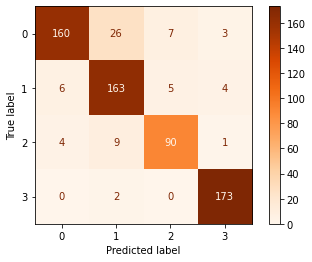

In [98]:
conf_matrix_plot(cm1)

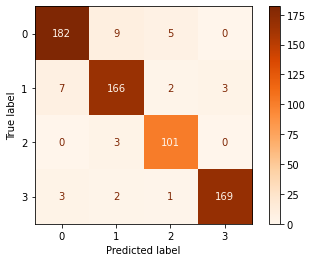

In [99]:
conf_matrix_plot(cm2)

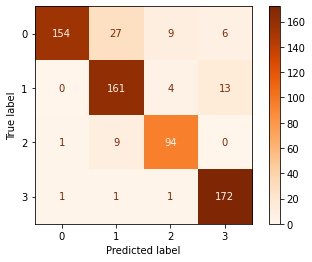

In [100]:
conf_matrix_plot(cm3)

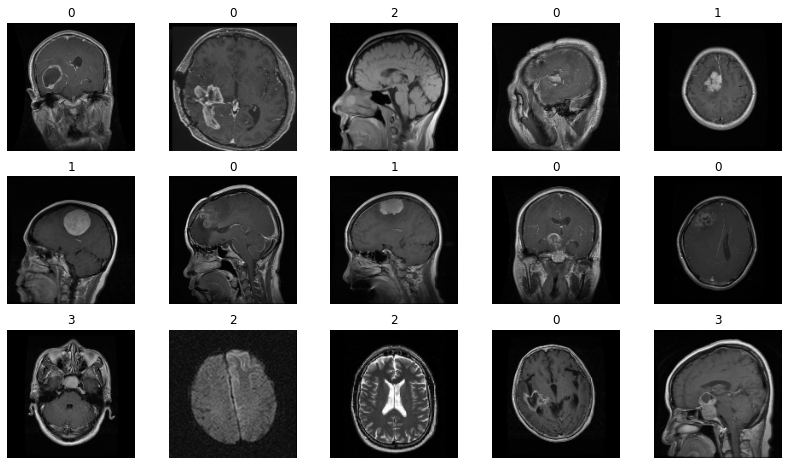

In [109]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(14, 8))       
ax = ax.ravel()

for j in range(5):
    ax[j].imshow(X_test[j]/255)
    ax[j].set_title(pred[j])
    ax[j].axis('off')
for k in range(5):
    ax[k+j+1].imshow(X_test[k+j+1]/255)
    ax[k+j+1].set_title(pred2[j+k+1])
    ax[k+j+1].axis('off')
for l in range(5):
    ax[l+k+j+2].imshow(X_test[l+k+j+2]/255)
    ax[l+k+j+2].set_title(pred2[l+j+k+2])
    ax[l+k+j+2].axis('off')

<h3>Summary</h3>

In [53]:
dictionary = {'CNN': [0.94, 0.81, 0.88, 0.96, 0.90], 'EfficientNetV2S':[0.95, 0.92, 0.93, 0.98, 0.95], 'RandomForestClassifier':[0.99, 0.81, 0.87, 0.90, 0.89]}
df = pd.DataFrame(dictionary)
df = df.rename(index={0: labels[0], 1: labels[1], 2: labels[2], 3: labels[3], 4: "all"})
df

,CNN,EfficientNetV2S,RandomForestClassifier
glioma_tumor,0.94,0.95,0.99
meningioma_tumor,0.81,0.92,0.81
no_tumor,0.88,0.93,0.87
pituitary_tumor,0.96,0.98,0.90
all,0.90,0.95,0.89
